# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


2022-04-05 13:49:33.081342: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [2]:
tf.config.list_physical_devices()

2022-04-05 13:50:04.039761: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-04-05 13:50:04.040901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-05 13:50:04.040928: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-05 13:50:04.048430: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-05 13:50:04.052288: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-04-05 13:50:04.054855: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-04-05 13:50:04.058231: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [3]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/20210925_152115_data.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [4]:
mp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel


### Load in the Data

In [5]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [6]:
info = {}

In [8]:
nds = flatten_nav(sample.raw_data.data)

In [9]:
nds.shape

(65025, 476, 476)

In [10]:
ds = hs.load(dp)

In [11]:
#flat_dps = flatten_nav(ds.data)
flat_dps = nds

In [12]:
flat_dps.shape

(65025, 476, 476)

In [138]:
best_map = np.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/bestmap7.npy')+1

<IPython.core.display.Javascript object>


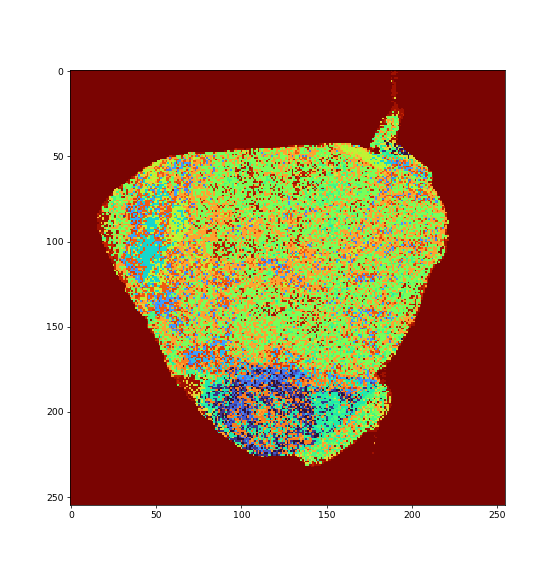

In [139]:
plt.figure()
plt.imshow(best_map, cmap='turbo', interpolation='nearest')

In [15]:
crystal_mask = ds.data.copy()

In [16]:
sx, sy = crystal_mask.shape[2]//2, crystal_mask.shape[3]//2

In [17]:
crystal_mask[:,:,sx-10:sx+10, sy-10:sy+10] = np.zeros((20,20))

In [18]:
patt_ints = crystal_mask.sum(axis = (2,3))

In [19]:
mask = np.where(patt_ints>1000,1,0)

In [20]:
masked_best_map = best_map*mask

<IPython.core.display.Javascript object>


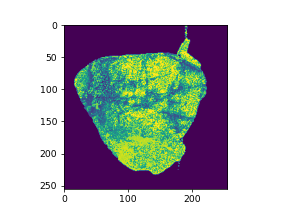

In [21]:
plt.figure()
plt.imshow(masked_best_map)

In [1]:
np.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/bestmap5.npy', masked_best_map)

NameError: name 'np' is not defined

In [22]:
masked_ds = ds.data.copy()

In [23]:
masked_ds[np.where(patt_ints<1000)]= np.mean(masked_ds[np.where(patt_ints<1000)],axis = 0)

In [ ]:
mds = hs.signals.Signal2D(masked_ds)

In [36]:
mds.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/mask_ds.hdf5')

In [7]:
masked_ds = hs.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/mask_ds.hdf5').data

In [8]:
masked_best_map = np.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/bestmap7.npy')

In [9]:
flat_dps = flatten_nav(masked_ds)

In [10]:
flat_bm = flatten_nav(masked_best_map)

In [11]:
[len(np.where(flat_bm ==uind)[0]) for uind in np.unique(flat_bm)]

[459,
 630,
 354,
 574,
 986,
 344,
 560,
 1075,
 1537,
 8015,
 353,
 607,
 583,
 267,
 6626,
 1002,
 1341,
 843,
 1040,
 918,
 36911]

In [12]:
nsamples = np.min([len(np.where(flat_bm ==uind)[0]) for uind in np.unique(flat_bm)])

In [13]:
nrepeats = np.sort([len(np.where(flat_bm ==uind)[0]) for uind in np.unique(flat_bm)])[-2] //nsamples

In [14]:
print(nsamples, nrepeats)

267 30


In [15]:
resample_ds = []
nl_resample_ds = []
for uind in np.unique(flat_bm):
    print(uind)
    pdf = np.where(flat_bm ==uind, 1, 0)
    npdf = pdf/pdf.sum()
    for i in range(10):
        sdps = hs.signals.Signal2D(flat_dps[np.random.choice(np.arange(flat_dps.shape[0]), nsamples, False, npdf)])
        pn_dps = sdps.copy()
        nl_resample_ds.append(sdps.data)
        pn_dps.add_poissonian_noise()
        resample_ds.append(pn_dps)

0.0


1.0


2.0


3.0


4.0


5.0


6.0


7.0


8.0


9.0


10.0


11.0


12.0


13.0


14.0


15.0


16.0


17.0


18.0


19.0


20.0


In [16]:
resample_ds = np.concatenate([x.data for x in resample_ds],axis = 0)
nl_resample_ds = np.concatenate([x for x in nl_resample_ds],axis = 0)

In [17]:
nl_resample_ds.shape

(56070, 476, 476)

np.random.shuffle(nl_resample_ds)

In [18]:
def data_manip_lowq_resized(d, central_box = 256, bs = 256):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 

In [19]:
input_data = data_manip_lowq_resized(resample_ds)
#np.random.shuffle(input_data)
input_targets = data_manip_lowq_resized(nl_resample_ds)
val_data = data_manip_lowq_resized(nl_resample_ds[::100])
#np.random.shuffle(val_data)


started data manipulations
resized
6
started data manipulations
resized
6
started data manipulations
resized
49


In [20]:
from sklearn.utils import shuffle
input_data, input_targets = shuffle(input_data, input_targets)

<IPython.core.display.Javascript object>


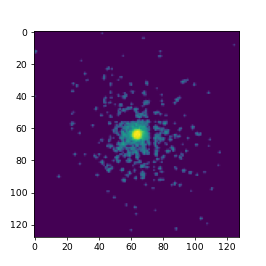

<IPython.core.display.Javascript object>


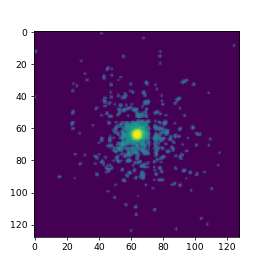

In [21]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
plt.figure(figsize = (4,4))
plt.imshow(input_targets[rand_patt])

##### Otherwise just skip

In [22]:
print(input_data.shape)

(56070, 128, 128)


In [23]:
batch_size = 1024

train_gen = Array_Generator(input_targets, batch_size, target = input_data)
valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

<IPython.core.display.Javascript object>


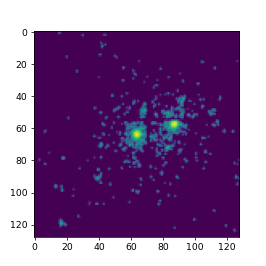

In [24]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])

### Set the checkpointing

In [25]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [26]:
rebin_factor = 1

In [27]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

2022-04-05 13:59:18.149259: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 13:59:18.161526: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-04-05 13:59:18.166685: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556e71557e90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-05 13:59:18.166713: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-05 13:59:18.298183: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556e71921e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-05 13:59:18.

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [37]:
old_model_path ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-572-1.35383e+03.hdf5'

In [38]:
old_model = create_vae_model(hparams)
old_model.load_weights(old_model_path)

In [39]:
def transfer_layer_weights(old_model, new_model, enc_layer_list, dec_layer_list):
    for l in enc_layer_list:
        w = old_model.get_layer(index = 0).get_layer(index=l).get_weights()
        new_model.get_layer(index = 0).get_layer(index=l).set_weights(w)

    for l in dec_layer_list:
        w = old_model.get_layer(index = 1).get_layer(index=l).get_weights()
        new_model.get_layer(index = 1).get_layer(index=l).set_weights(w)
    return new_model

In [40]:
old_model.encoder.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 64, 64, 32)   832         enc_input[0][0]                  
__________________________________________________________________________________________________
enc_conv2 (Conv2D)              (None, 32, 32, 64)   51264       enc_conv1[0][0]                  
__________________________________________________________________________________________________
enc_conv3 (Conv2D)              (None, 16, 16, 128)  204928      enc_conv2[0][0]                  
_______________________________________________________________________________________

In [41]:
enc_layer_list = list(range(7))

In [42]:
old_model.decoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input_t (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dec_d1_t (Dense)             (None, 512)               1536      
_________________________________________________________________
dec_d2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d3 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d4 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d5 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d6 (Dense)               (None, 512)             

In [43]:
dec_layer_list = list(range(9,14))

In [44]:
vae_model = transfer_layer_weights(old_model, vae_model, enc_layer_list, dec_layer_list)

### Train the Model

In [45]:
history = vae_model.fit(train_gen,validation_data=valid_gen, epochs=10000, callbacks= [chkpoint_model])

Epoch 1/10000
55/55 [==============================] - ETA: 0s - loss: 1362.4237
Epoch 00001: val_loss did not improve from 1353.69287
55/55 [==============================] - 14s 261ms/step - loss: 1362.4237 - val_loss: 1353.8834
Epoch 2/10000
55/55 [==============================] - ETA: 0s - loss: 1374.7229
Epoch 00002: val_loss did not improve from 1353.69287
55/55 [==============================] - 14s 261ms/step - loss: 1374.7229 - val_loss: 1353.7953
Epoch 3/10000
55/55 [==============================] - ETA: 0s - loss: 1351.7448
Epoch 00003: val_loss did not improve from 1353.69287
55/55 [==============================] - 14s 261ms/step - loss: 1351.7448 - val_loss: 1354.1075
Epoch 4/10000
55/55 [==============================] - ETA: 0s - loss: 1345.1304
Epoch 00004: val_loss did not improve from 1353.69287
55/55 [==============================] - 14s 261ms/step - loss: 1345.1304 - val_loss: 1354.4331
Epoch 5/10000
55/55 [==============================] - ETA: 0s - loss: 1352.

KeyboardInterrupt: 

In [97]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/ntest.hdf5')